In [1]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
import csv
import werthmuller_201 as wdlf
import matplotlib.pyplot as plt

In [2]:
#フィルタの入力
ybase, j0=wdlf.base, wdlf.j0

# 初期値の設定

In [3]:
#送信電流値
current=1

#探索範囲(上限)
PED=[np.log10(200), np.log10(50), np.log10(200), np.log10(10), np.log10(10)]
#探索範囲(下限)
PST=[np.log10(1), np.log10(0.1), np.log10(1), np.log10(0.5), np.log10(0.5)]

##GAの設定
#試行回数
trial=20

#打ち切り相対誤差
StopRMSPE=0.01

#相の数
nLayer=int((len(PED)+1)/2)

#染色体の数
MP=len(PED)

#最大世代数
maxiter=100

#個体数
nPop=200

#ビット数
nBit=8

#エリート数
elite=1

#交叉率
crate=0.9

#突然変異率
mrate=0.002

#交叉手法(1→1点交叉、2→2点交叉、3→一様交叉)
ctype=3

# 関数の定義

In [4]:
#CSVファイルの読み込み
def read():
    with open('ObsData2023.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        data = []
        for row in reader:
            data.append(row)

    a=np.zeros(int(np.size(data)/2-1))
    ras1=np.zeros(int(np.size(data)/2-1))
    for k in range(int(np.size(data)/2-1)):
        a[k]=data[k+1][0]
        ras1[k]=data[k+1][1]
    return(a,ras1)

In [5]:
#初期世代の生成する関数
def chromosome(nBit):
    return [random.randint(0, 1) for i in range(nBit)]

def individual(MP,nBit):
    return [chromosome(nBit) for i in range(MP)]

def generation(nPop,MP,nBit):
    return [individual(MP,nBit) for i in range(nPop)]

In [6]:
#適応度の計算
def Fitness(PED,PST,nLayer,nn,current,a,obsData,DNA,nPop,MP,nBit):
    fitness=np.zeros(nPop)
    #2進数を10進数にする
    n10=n2ton10(DNA)
    #上下限付き対数空間への変換
    x1=10**conv(n10,PED,PST,nBit)

    rho=np.zeros((nPop,nLayer))
    thickness=np.zeros((nPop,nLayer-1))
    fitness=np.zeros(nPop)
    appres=np.zeros((nPop,nn))
    Fitness=np.zeros(nPop)

    for ii in range(nPop):
        rho[ii][:]=x1[ii][0:nLayer]
        thickness[ii][:]=x1[ii][nLayer:MP]
        appres[ii][:]=dc1dwenner(rho[ii][:],thickness[ii][:],current,a)
        fitness[ii]=nPop/sum((np.log10(appres[ii][:])-obsData)**2)
    return(appres,fitness)

In [7]:
#ルーレット盤の作成
def roulette(fitness,nPop):
    sumv=np.sum(fitness)
    q=np.zeros(nPop)
    q[0]=fitness[0]/sumv
    for ir in range(1,nPop):
        q[ir]=q[ir-1]+fitness[ir]/sumv
    return(q)

In [8]:
#ルーレットから次世代参加個体の選択
def select(DNA,q,nPop,MP,nBit):
    ns=np.zeros(nPop)
    selectDNA=np.zeros((nPop,MP,nBit))

    for ii in range(nPop):
        rout=random.random()
        for jj in range(nPop):
            if q[jj] > rout:
                selectDNA[ii][:][:]=DNA[jj][:][:]
                break
    return(selectDNA)

In [9]:
#一点交叉
def cross1(DNA,eliteDNA,MP,nBit,crate,nPop,elite):
    nc=0
    dammy_ns=np.zeros(nPop)
    for ii in range(nPop-elite):
        rand=random.random()
        #print(ii)
        #print(rand)
        if rand <= crate:
            dammy_ns[nc]=ii
            nc=nc+1
    ns=np.zeros(nc)
    ns=dammy_ns[0:nc]
    
    if nc%2 != 0:
        nc=nc+1
        ns=np.zeros(nc)
        ns[0:nc-1]=dammy_ns[0:nc-1]
        rand=random.random()
        ns[nc-1]=np.fix(nPop*rand)      
    
    newDNA=np.zeros((nPop,MP,nBit))
    for ii in range(int(nc/2)):
        i1=2*ii
        i2=2*ii+1

        for jj in range(MP):
            rand=random.random()
            cutpoint=np.fix((nBit-1)*rand)+1
            cutpoint=int(cutpoint)

            newDNA[i1][jj][0:cutpoint]=DNA[int(ns[i1])][jj][0:cutpoint]
            newDNA[i2][jj][0:cutpoint]=DNA[int(ns[i2])][jj][0:cutpoint]
        
            newDNA[i1][jj][cutpoint:nBit]=DNA[int(ns[i2])][jj][cutpoint:nBit]
            newDNA[i2][jj][cutpoint:nBit]=DNA[int(ns[i1])][jj][cutpoint:nBit]
  
    for ii in range(nc):
        DNA[int(ns[ii])][:][:]=newDNA[ii][:][:]
#    DNA[int(ns[ii])][:][:]=newDNA[ii][:][:] 　多染色体の場合

    if elite == 1:
        DNA[nPop-1][:][:]=eliteDNA[:][:]
    return(DNA)

In [10]:
#二点交叉
def cross2(DNA,eliteDNA,MP,nBit,crate,nPop,elite):
    nc=0
    dammy_ns=np.zeros(nPop)
    for ii in range(nPop-elite):
        rand=random.random()
        if rand <= crate:
            dammy_ns[nc]=ii
            nc=nc+1
    ns=np.zeros(nc)
    ns=dammy_ns[0:nc]

    if nc%2 != 0:
        nc=nc+1
        ns=np.zeros(nc)
        ns[0:nc-1]=dammy_ns[0:nc-1]
        rand=random.random()
        ns[nc-1]=np.fix(nPop*rand)      

    newDNA=np.zeros((nPop,MP,nBit))
    for ii in range(int(nc/2)):
        i1=2*ii
        i2=2*ii+1

        for jj in range(MP):        
            rand=random.random()
            cutpoint2=np.fix((nBit-2)*rand)+2
            cutpoint2=int(cutpoint2)

            rand=random.random()
            cutpoint1=np.fix((cutpoint2-1)*rand)+1
            cutpoint1=int(cutpoint1)

            newDNA[i1][jj][0:cutpoint1]=DNA[int(ns[i1])][jj][0:cutpoint1]
            newDNA[i2][jj][0:cutpoint1]=DNA[int(ns[i2])][jj][0:cutpoint1]

            newDNA[i1][jj][cutpoint1:cutpoint2]=DNA[int(ns[i2])][jj][cutpoint1:cutpoint2]
            newDNA[i2][jj][cutpoint1:cutpoint2]=DNA[int(ns[i1])][jj][cutpoint1:cutpoint2]

            newDNA[i1][jj][cutpoint2:nBit]=DNA[int(ns[i1])][jj][cutpoint2:nBit]
            newDNA[i2][jj][cutpoint2:nBit]=DNA[int(ns[i2])][jj][cutpoint2:nBit]

    for ii in range(nc):
        DNA[int(ns[ii])][:][:]=newDNA[ii][:][:]
    #   DNA[int(ns[ii])][:][:]=newDNA[ii][:][:] 　多染色体の場合


    if elite == 1:
        DNA[nPop-1][:][:]=eliteDNA[:][:]
    return(DNA)

In [11]:
#一様交叉
def crossu(DNA,eliteDNA,MP,nBit,crate,nPop,elite):
    nc=0
    dammy_ns=np.zeros(nPop)
    for ii in range(nPop-elite):
        rand=random.random()
        if rand <= crate:
            dammy_ns[nc]=ii
            nc=nc+1
    ns=np.zeros(nc)
    ns=dammy_ns[0:nc]

    if nc%2 != 0:
        nc=nc+1
        ns=np.zeros(nc)
        ns[0:nc-1]=dammy_ns[0:nc-1]
        rand=random.random()

    newDNA=np.zeros((nPop,MP,nBit))
    mDNA=np.zeros(nBit)
    for ii in range(int(nc/2)):
        i1=2*ii
        i2=2*ii+1
    
        for jj in range(MP):
            mDNA=chromosome(nBit)
            crossindex=[index for index, value in enumerate(mDNA) if value == 1] 
            size=len(crossindex)

            newDNA[i1][jj][:]=DNA[int(ns[i1])][jj][:]
            newDNA[i2][jj][:]=DNA[int(ns[i2])][jj][:]
        
            for kk in range(size):
                newDNA[i1][jj][crossindex[kk]]=DNA[int(ns[i2])][jj][crossindex[kk]]
                newDNA[i2][jj][crossindex[kk]]=DNA[int(ns[i1])][jj][crossindex[kk]]
        
    for ii in range(nc):
        DNA[int(ns[ii])][:][:]=newDNA[ii][:][:]
    #   DNA[int(ns[ii])][:][:]=newDNA[ii][:][:] 　多染色体の場合

    if elite == 1:
        DNA[nPop-1][:][:]=eliteDNA[:][:]
    return(DNA)

In [12]:
#突然変異
def mutate(DNA,eliteDNA,nPop,elite,mrate):
    DNA=[[[int(0) if random.random() < mrate and num == 1 else int(1) if random.random() < mrate and num == 0 else int(num) for num in inner] for inner in middle] for middle in DNA]
    if elite == 1:
        DNA[nPop-1][:][:]=eliteDNA[:][:]
    return (DNA)

In [13]:
#2進数から10進数にする関数
def n2ton10(n2):
    n10=[[int(''.join(str(bit) for bit in inner), 2) for inner in middle] for middle in n2]
    return(n10)

In [14]:
#上下限付き対数空間への変換
def conv(n10,PED,PST,nBit):
    x1=PST+(np.array(PED)-np.array(PST))*n10/(2**nBit-1)
    return(x1)

In [15]:
#Wenner法を解く関数
def wenner(rx,rho,thickness,current):
    N=len(rho)
    FilterLength=len(ybase)
    T=np.zeros((FilterLength,N))
    numLocation=len(rx)
    phi=np.zeros(numLocation)
    Lambda=np.zeros(FilterLength)
    bns=np.zeros(FilterLength)
    bnb=np.zeros(FilterLength)
    T[:,-1]=rho[-1]
#外側ループ
    k=0
    for r in range(numLocation):
        Lambda[:]=ybase[:]/rx[r]
#内側ループ
        for ii in range(N-1,0,-1):
            bns[:]=T[:,ii]+rho[ii-1]*np.tanh(Lambda[:]*thickness[ii-1])
            bnb[:]=1+T[:,ii]*np.tanh(Lambda[:]*thickness[ii-1])/rho[ii-1]
            T[:,ii-1]=bns[:]/bnb[:]
        phi[k]=current*sum(T[:,0]*j0[:])/(2*math.pi*rx[k])
        k=k+1
    return(phi)

In [16]:
#電気探査の順解析を行う関数
def dc1dwenner(rho,thickness,current,a):
    data_num=len(a)
    V=np.zeros(data_num)
    appres=np.zeros(data_num)

    for iter in range(data_num):
        rx=np.array([a[iter],2*a[iter]])
        phi1=wenner(rx,rho,thickness,current)

        rx=np.array([2*a[iter],a[iter]])
        phi2=wenner(rx,rho,thickness,current)

        V1=phi1[0]-phi2[0]
        V2=phi1[1]-phi2[1]
        V[iter]=abs(V1-V2)
        appres[iter]=2*math.pi*a[iter]*V[iter]/current
    return(appres)

# ↓ここから計算開始

In [17]:
#データの読み取り(a→電極間隔、ras1→比抵抗)
a,ras1=read()
nn=len(a) #電極間隔の数
obsData=np.log10(ras1) #観測値を対数で扱う

#箱の設定#################
DNA=np.zeros((nPop,MP,nBit))
appres=np.zeros((nPop,nn))
fitness=np.zeros(nPop)
##########################
#箱の設定#################
number=np.zeros(maxiter)
eliteDNA=np.zeros((MP,nBit))
q=np.zeros(nPop)
selectDNA=np.zeros((nPop,MP,nBit))
RMSPE=np.zeros(maxiter)
RMSPE_opt=np.zeros(maxiter)
appres_opt=np.zeros(nn)
##########################

RMSPE_min=10

for trial_num in range(trial):    
    DNA=generation(nPop,MP,nBit)
    appres,fitness=Fitness(PED,PST,nLayer,nn,current,a,obsData,DNA,nPop,MP,nBit)
    for iter in range(maxiter):
        number[iter]=iter+1
        elite_num=np.argmax(fitness)
        eliteDNA[:][:]=DNA[elite_num][:][:]
        q=roulette(fitness,nPop)
        selectDNA=select(DNA,q,nPop,MP,nBit)
        if ctype==1:
            crossDNA=cross1(selectDNA,eliteDNA,MP,nBit,crate,nPop,elite)
        elif ctype==2:
            crossDNA=cross2(selectDNA,eliteDNA,MP,nBit,crate,nPop,elite)
        else:
            crossDNA=crossu(selectDNA,eliteDNA,MP,nBit,crate,nPop,elite)

        DNA=mutate(crossDNA,eliteDNA,nPop,elite,mrate)

        appres,fitness=Fitness(PED,PST,nLayer,nn,current,a,obsData,DNA,nPop,MP,nBit)
        elite_num=np.argmax(fitness)
        RMSPE[iter]=100*np.sqrt(sum(((appres[elite_num][:]-ras1[:])/ras1[:])**2)/nn)
        print(RMSPE[iter])
    
    if RMSPE[maxiter-1]<RMSPE_min:
        RMSPE_min=RMSPE[maxiter-1]
        RMSPE_opt[:]=RMSPE[:]
        appres_opt[:]=appres[elite_num][:]
        #2進数を10進数にする
        n10=n2ton10(DNA)
        #上下限付き対数空間への変換
        x1=10**conv(n10,PED,PST,nBit) 

14.132324618409603
6.150780694899134
4.156573426330777
3.7033896731556966
1.8459004654848126
1.849541792705597
1.2743220814523641
0.7542110007247059
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761806
0.4930090357761

6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.2608043253020815
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.2608043253020815
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.277974678407136
6.386096171947451
12.230127687735722
11.7178495529543
9.608431

1.8900685163992639
16.266057231100135
15.228866708920256
9.211007450706434
9.211007450706434
6.4784148081539845
6.4784148081539845
5.007825307421529
4.0151476427479675
3.7537469737751876
3.7537469737751876
3.7537469737751876
3.7071778777638795
3.7071778777638795
3.4307902151813905
3.421789946723276
3.421789946723276
3.421789946723276
3.421789946723276
3.421789946723276
3.421789946723276
3.421789946723276
3.421789946723276
3.421789946723276
3.421789946723276
3.421789946723276
3.3327204947161087
3.3327204947161087
3.3327204947161087
3.3327204947161087
3.3327204947161087
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.3312825388116516
3.33128

11.39515307804778
11.39515307804778
11.310485311966582
11.310485311966582
11.310485311966582
11.310485311966582
11.310485311966582
11.310485311966582
11.493772244860228
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.38426524194895
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.493772244860228
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.408083007218956
11.442729

4.175269200749291
4.175269200749291
4.175269200749291
4.175269200749291
14.61896410930763
8.521216423576238
8.065013566640348
5.934253981519202
5.934253981519202
5.4369349588298075
4.962828250397837
5.04566943696522
4.962828250397837
4.933211523061236
4.706840285116054
4.382522027365681
4.382522027365681
4.37644689209764
4.37644689209764
4.37644689209764
4.285640747612049
4.37644689209764
3.3899320744009054
3.5152116778027187
3.3899320744009054
3.3899320744009054
3.0156714328777943
3.0156714328777943
3.0156714328777943
3.0156714328777943
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364
2.9741904572692364


# 試行回数回した後に、そのなかで最終的にRMSPEが一番小さくなるときの試行におけるエリートDNAを採用する。

Text(0, 0.5, 'RMSPE')

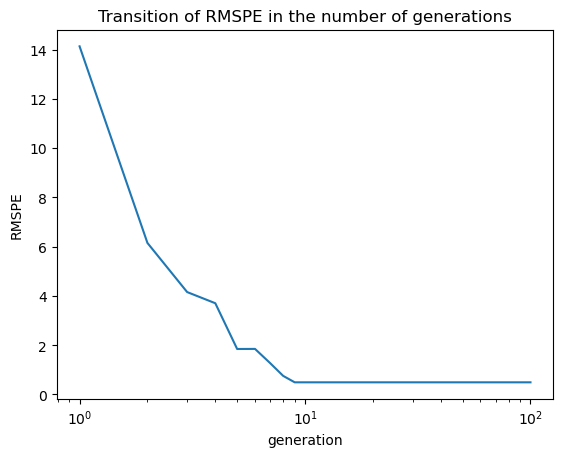

In [18]:
plt.plot(number,RMSPE_opt)
plt.title("Transition of RMSPE in the number of generations")
plt.xscale('log')
plt.xlabel("generation")
plt.ylabel("RMSPE")

Text(0, 0.5, 'depth m')

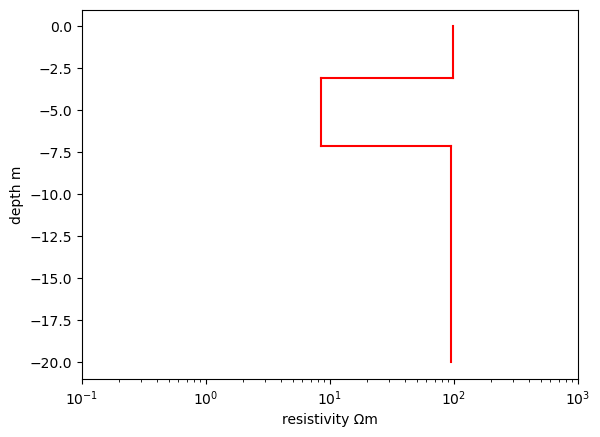

In [21]:
x_con1=np.ones(100)
x_con2=np.ones(100)
x_con3=np.ones(100)

x_con1=x_con1*x1[elite_num][0]
y_con1=np.linspace(0,-x1[elite_num][3],100)

x_con2=x_con2*x1[elite_num][1]
y_con2=np.linspace(-x1[elite_num][3],-x1[elite_num][3]-x1[elite_num][4],100)

x_con3=x_con3*x1[elite_num][2]
y_con3=np.linspace(-x1[elite_num][3]-x1[elite_num][4],-20,100)

x_con4=np.array((x1[elite_num][0],x1[elite_num][1]))
y_con4=np.array((-x1[elite_num][3],-x1[elite_num][3]))

x_con5=np.array((x1[elite_num][1],x1[elite_num][2]))
y_con5=np.array((-x1[elite_num][3]-x1[elite_num][4],-x1[elite_num][3]-x1[elite_num][4]))

plt.plot(x_con1,y_con1,color="red")
plt.plot(x_con2,y_con2,color="red")
plt.plot(x_con3,y_con3,color="red")
plt.plot(x_con4,y_con4,color="red")
plt.plot(x_con5,y_con5,color="red")

plt.xscale('log')
plt.xlim(0.1, 1000)
plt.xlabel("resistivity Ωm")
plt.ylabel("depth m")

図のように、地下0.0~2.5メートルまでは比抵抗が100Ωmの性質を持つ物質が存在する層、地下2.5~7.5メートルまでは比抵抗が10Ωmの性質を持つ物質が存在する層、
地下7.5~20.0メートルまでは比抵抗が100Ωmの性質を持つ物質が存在する層であることが得られた観測データから予測できた。

(0.1, 20.0)

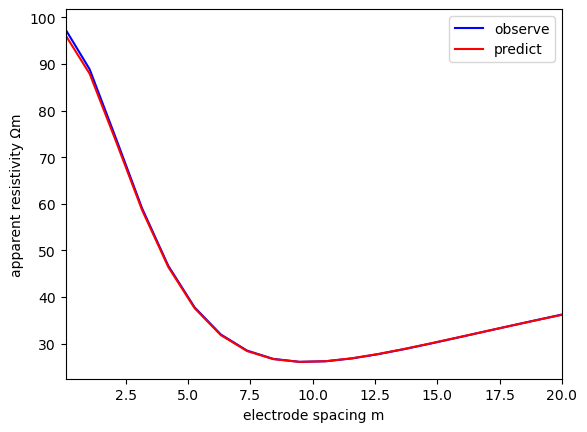

In [22]:
x=np.linspace(0,nn,nn)
plt.plot(x,ras1,label="observe",color="blue")
plt.plot(x,appres_opt,label="predict",color="red")
plt.legend()
plt.xlabel("electrode spacing m")
plt.ylabel("apparent resistivity Ωm")
plt.xlim(0.1, 20.0)

実際に最適化計算によって導かれた値を用いて順解析を行った結果、図のようにもとの観測データとほぼ一致していることがわかる。